# Init

In [1]:
import matplotlib.pylab as plt

import numpy as np
import pandas as pd
import seaborn as sns

from luescher_nd.zeta.zeta2d import Zeta2D

In [2]:
%load_ext blackcellmagic

# Comparison with Tom

Init the zeta functions

In [3]:
z_spherical = Zeta2D(40, spherical=True)
z_cartesian = Zeta2D(40, spherical=False)

Plot to compare with Tom

/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


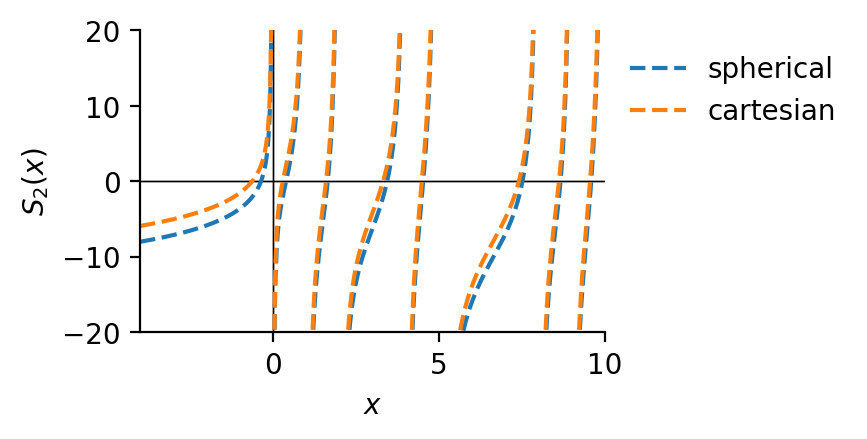

In [4]:
fig, ax = plt.subplots(figsize=(3,2), dpi=200)

tol = 40.0

x = np.linspace(-4, 10, 1002)

for z, key in zip([z_spherical, z_cartesian], ["spherical", "cartesian"]):
    y = z(x)
    y[y>tol] = np.inf
    y[y<-tol] = -np.inf

    ax.plot(x, y, ls="--", label=key)

    ax.axhline(0, color="black", lw=.5, ls="-", zorder=-1)
    ax.axvline(0, color="black", lw=.5, ls="-", zorder=-1)

sns.despine()

ax.legend(loc="upper left", bbox_to_anchor=(1,1), frameon=False)

ax.set_ylim(-20, 20)
ax.set_xlim(-4, 10)

ax.set_xlabel("$x$")
ax.set_ylabel("$S_2(x)$")

plt.show()

## ERE

Computation of Effective range expansion

In [5]:
from scipy.optimize import minimize_scalar

Assume fixed scattering length and box volume to solve Tom's equation (26)

In [6]:
a0 = 1.0
L = 1.0

lhs = 2 * np.pi * np.log(2 * np.pi * a0 / L) 

In [7]:
class MinKernel:
    def __init__(self, val, func):
        self.val = val
        self.func = func
        
    def chi2(self, x):
        return (self.val - self.func(x))**2

Exactly extrac the ground state by finding the intersections between zeta and $\cot(\delta_o(x))$ (is it the ground state though?)

In [8]:
kernel_spherical = MinKernel(lhs, z_spherical)
kernel_cartesian = MinKernel(lhs, z_cartesian)

x0_spherical = minimize_scalar(kernel_spherical.chi2, bracket=(0, 0.5), tol=1.e-12).x[0]
x0_cartesian = minimize_scalar(kernel_cartesian.chi2, bracket=(0, 0.5), tol=1.e-12).x[0]

In [9]:
def ere(y, x):
    return y / np.pi**2 + 1 / np.pi * np.log(x)

Plot intersection

/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


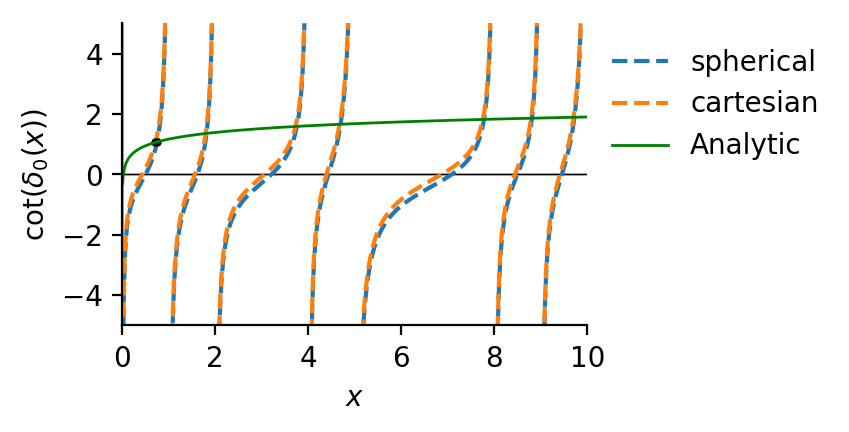

In [10]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=200)

tol = 80.0
x = np.linspace(0, 10, 1002)

for z, key in zip([z_spherical, z_cartesian], ["spherical", "cartesian"]):
    y = z(x)
    y[y > tol] = np.inf
    y[y < -tol] = -np.inf

    ax.plot(x, ere(y, x), ls="--", label=key)

    ax.axhline(0, color="black", lw=0.5, ls="-", zorder=-1)
    ax.axvline(0, color="black", lw=0.5, ls="-", zorder=-1)

ax.plot(
    x0_spherical,
    ere(z_spherical(x0_spherical), x0_spherical),
    marker="o",
    ms=2,
    color="black",
    zorder=2,
)
ax.plot(
    x0_cartesian,
    ere(z_cartesian(x0_cartesian), x0_cartesian),
    marker="o",
    ms=2,
    color="black",
    zorder=2,
)

sns.despine()

ax.plot(
    x,
    2 / np.pi * np.log(a0 * 2 * np.pi * np.sqrt(x) / L),
    color="green",
    ls="-",
    lw="1",
    label="Analytic",
)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)

ax.set_ylim(-5, 5)
ax.set_xlim(0, 10)

ax.set_xlabel("$x$")
ax.set_ylabel("$\cot(\delta_0(x))$")

plt.show()


# Fit FV discrete Hamiltonian to ground state

In [11]:
from luescher_nd.hamiltonians.contact import MomentumContactHamiltonian
from luescher_nd.operators import get_parity_projector

from scipy.sparse.linalg import eigsh

In [12]:
n1d = 20
epsilon = L / n1d
ndim = 2
nstep = None
mass = 4.758
mu = mass / 2

p_minus = get_parity_projector(n1d, ndim, positive=False)

def get_first_state(contact_strength):

    eigs = np.sort(eigsh(MomentumContactHamiltonian(
        contact_strength=-np.exp(contact_strength),
        n1d=n1d,
        epsilon=epsilon,
        mass=mass,
        ndim=ndim,
        nstep=nstep,
        filter_out=p_minus,
        filter_cutoff=1.0e2,
    ).op, return_eigenvectors=False, k=5, which="SA"))
    return eigs[1]

Note that I do not fit the ground state but the first excited state ($x>0$).

In [13]:
contact_fitter_spherical = MinKernel(
    x0_spherical * (2 * np.pi / L) ** 2 / 2 / mu, get_first_state
)
contact_fitter_cartesian = MinKernel(
    x0_cartesian * (2 * np.pi / L) ** 2 / 2 / mu, get_first_state
)

c0_spherical = minimize_scalar(contact_fitter_spherical.chi2, tol=1.e-12).x
c0_cartesian = minimize_scalar(contact_fitter_cartesian.chi2, tol=1.e-12).x

# Plot computed ERE

get spectrum

In [14]:
h_spherical = MomentumContactHamiltonian(
        contact_strength=-np.exp(c0_spherical),
        n1d=n1d,
        epsilon=epsilon,
        mass=mass,
        ndim=ndim,
        nstep=nstep,
        filter_out=p_minus,
        filter_cutoff=1.0e2,
    )
h_cartesian = MomentumContactHamiltonian(
        contact_strength=-np.exp(c0_cartesian),
        n1d=n1d,
        epsilon=epsilon,
        mass=mass,
        ndim=ndim,
        nstep=nstep,
        filter_out=p_minus,
        filter_cutoff=1.0e2,
    )

eigs_spherical = eigsh(h_spherical.op, return_eigenvectors=False, k=20, which="SA")
eigs_caresian = eigsh(h_cartesian.op, return_eigenvectors=False, k=20, which="SA")

In [15]:
x_spherical = np.sort(eigs_spherical) * 2 * mu * L**2 / 4 / np.pi**2
x_cartesian = np.sort(eigs_caresian) * 2 * mu * L**2 / 4 / np.pi**2

/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/christopherkorber/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


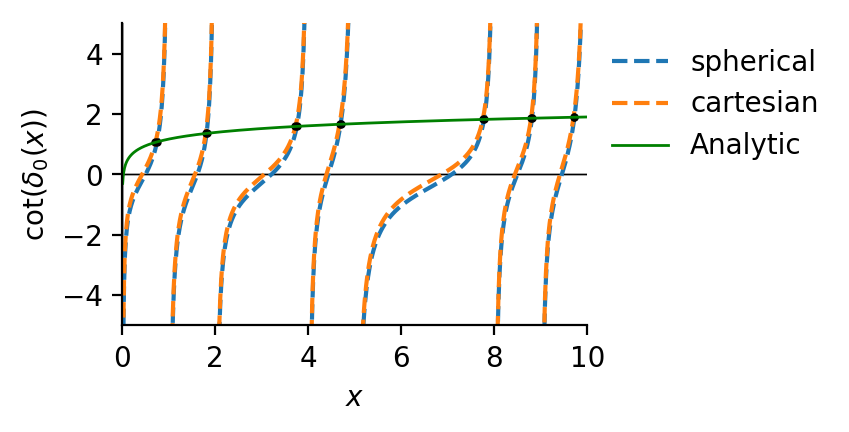

In [16]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=200)

tol = 80.0
x = np.linspace(0, 10, 1002)

for z, key in zip([z_spherical, z_cartesian], ["spherical", "cartesian"]):
    y = z(x)
    y[y > tol] = np.inf
    y[y < -tol] = -np.inf

    ax.plot(x, ere(y, x), ls="--", label=key)

    ax.axhline(0, color="black", lw=0.5, ls="-", zorder=-1)
    ax.axvline(0, color="black", lw=0.5, ls="-", zorder=-1)

ax.plot(
    x_spherical,
    ere(z_spherical(x_spherical), x_spherical),
    marker="o",
    ms=2,
    ls="None",
    color="black",
    zorder=2,
)
ax.plot(
    x_cartesian,
    ere(z_cartesian(x_cartesian), x_cartesian),
    marker="o",
    ms=2,
    ls="None",
    color="black",
    zorder=2,
)

sns.despine()

ax.plot(
    x,
    2 / np.pi * np.log(a0 * 2 * np.pi * np.sqrt(x) / L),
    color="green",
    ls="-",
    lw="1",
    label="Analytic",
)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)

ax.set_ylim(-5, 5)
ax.set_xlim(0, 10)

ax.set_xlabel("$x$")
ax.set_ylabel("$\cot(\delta_0(x))$")

plt.show()

